# Web Scraping and Introductory Data Analysis



### purpose of this assignment
- Write a web scraping script using Beautiful Soup and Selenium to collect data from a website.
- Sample from the collected dataset and compare the statistics of the sample and the population.

### Environment Setup

Create the virtualenv by running the following command:

`python -m venv .venv`

Activate the virtualenv by runnig the following command:

windows:
`.venv/Scripts/activate`

linux:
`source .venv/bin/activate`

Now install packages using pip. Install pakages by runnig the following cell:

`pip install -r ./../requirements.txt`

In [6]:
# %pip install -r ./../requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from ydata_profiling  import ProfileReport
from scipy.stats import norm
from sklearn.utils import resample

## Data Collection

In [2]:
NUMBER_BLOCKS = 10
ETHERESCAN_URL = "https://etherscan.io/txs"

### Web Scraping
**Class: $EthereumScraping$**

This class is designed to scrape Ethereum transaction data from Etherscan. It offers functionalities to:

- Extract data from a specified number of blocks (`number_block`)
- Clean and organize the extracted data into a pandas DataFrame
- Handle web scraping using Selenium (specifically ChromeDriver)

**Properties:**

- `url` (str): The base URL for Etherscan's transaction search page (likely retrieved from an environment variable named `ETHERESCAN_URL`).
- `columns` (list): A list of column names for the DataFrame to be created (`['tnx_hash', 'method', 'block', 'date', 'from', 'to', 'value', 'tnx_fee']`).
- `number_block` (int, default=10): The desired number of blocks to scrape data from.
- `driver` (Optional[webdriver.Chrome]): A reference to the ChromeDriver instance used for web scraping (initialized during the first scraping operation).
- `df` (pd.DataFrame): The DataFrame that stores the scraped transaction data, with columns defined in `columns`.

**Methods:**

- `__init__(self, number_block: int=10) -> None`
  - Initializes the class instance with the specified `number_block`.
  - Sets `driver` to `None` initially.
  - Creates an empty DataFrame with the columns specified in `columns`.

- `__del__(self) -> None` (Destructor)
  - Closes the ChromeDriver instance if it's open to avoid resource leaks.

- `_get_data_from_td_tag(self, element: bs4.element.Tag) -> str` (Private)
  - Extracts the text content from an anchor (`<a>`) tag within a table data cell (`<td>`) element.
  - Splits the extracted URL by '/' and returns the last element, which is typically the transaction hash.

- `_collect_data_from_tr_tag(self, elements: bs4.element.ResultSet) -> pd.core.series.Series` (Private)
  - Takes a collection of table cell elements (`elements`) from a table row (`<tr>`).
  - Creates a pandas Series with the following data (extracted from corresponding cell indices):
    - Method name (index: 'method')
    - Block number (index: 'block') (converted to integer)
    - Date (index: 'date')
    - From address (index: 'from')
    - To address (index: 'to')
    - Transaction value (index: 'value')
    - Transaction fee (index: 'tnx_fee')
  - Utilizes `_get_data_from_td_tag` to extract transaction hash and fee from anchor tags within specific cells.

- `_extract_data_from_html(self, html_content: str) -> int` (Private)
  - Parses the provided HTML content using BeautifulSoup.
  - Finds all table rows (`<tr>`) and iterates through them:
    - Extracts data from table cell elements (`<td>`) within each row using `_collect_data_from_tr_tag`.
    - Appends the extracted Series as a new row to the `df` DataFrame, ignoring the index during concatenation.
    - Keeps track of the maximum block number encountered.
  - Returns the maximum block number extracted from the HTML content.

- `_extract_data_from_url(self) -> int` (Private)
  - Retrieves the HTML content from the current URL using the `driver`'s `get_attribute("outerHTML")` method on the target element identified by the CSS selector `"tbody.align-middle.text-nowrap"`.
  - Calls `_extract_data_from_html` to parse the HTML and extract data.

- `_click_next_button(self) -> None` (Private)
  - Creates a WebDriverWait object with a 10-second timeout.
  - Waits for the "Next" button (`a[aria-label='Next']`) to become clickable using `element_to_be_clickable`.
  - Clicks the button if located, otherwise prints an error message and raises an exception.

- `_extract_data(self) -> None` (Private)
  - Initializes a ChromeDriver instance (`driver`) if it's not already set.
  - Navigates to the `url` using the `driver`.
  - Calls `_extract_data_from_url` to extract data from the initial page.
  

In [3]:
class EthereumScraping:
    url = ETHERESCAN_URL
    columns = ['tnx_hash', 'method', 'block', 'date', 'from', 'to', 'value', 'tnx_fee']

    def __init__(self, number_block: int=10) -> None:
        self.number_block = number_block
        self.driver = None
        self.df = pd.DataFrame(columns=self.columns)

    def __del__(self) -> None:
        if self.driver:
            self.driver.quit()

    def _get_data_from_td_tag(self, element: bs4.element.Tag) -> str:
        return element.find('a').get('href').split('/')[-1] 

    def _collect_data_from_tr_tag(self, elements: bs4.element.ResultSet)-> pd.core.series.Series:
        return pd.Series(
            [
                elements[1].text.strip(),
                elements[2].text.strip(),
                elements[3].text.strip(),
                elements[4].text.strip(),
                self._get_data_from_td_tag(elements[7]),
                self._get_data_from_td_tag(elements[9]),
                elements[10].text.strip(),
                elements[11].text.strip()
            ],
            index=self.columns

        ), int(elements[3].text.strip())


    def _extract_data_from_html(self, html_content: str) -> int:
        soup = BeautifulSoup(html_content, "html.parser")
        rows = soup.find_all("tr")
        block_number = 0
        for row in rows:
            cells = row.find_all("td")
            series, block = self._collect_data_from_tr_tag(cells)
            block_number = max(block_number, block)
            self.df = pd.concat([self.df, pd.DataFrame([series])], ignore_index=True)

        return block_number

            
    def _extract_data_from_url(self) -> int:
        return self._extract_data_from_html(
            self.driver.find_element(
                By.CSS_SELECTOR, "tbody.align-middle.text-nowrap"
            ).get_attribute("outerHTML")
        )
    
    def _click_next_button(self) -> None:
        try:
            WebDriverWait(self.driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, "a[aria-label='Next']"))
            ).click()
        except Exception as e:
            print(f"Error clicking the 'Next' button: {e}")
            raise

    def _extract_data(self) -> None:
        self.driver = webdriver.Chrome()
        self.driver.get(self.url)
        block_number = new_block_number  = self._extract_data_from_url()
        while (block_number - new_block_number) < self.number_block:
            self._click_next_button()
            new_block_number = self._extract_data_from_url()
        
    def scrap(self) -> pd.core.frame.DataFrame:
        self._extract_data()
        return self.df
        
      





In [6]:
scraptEther = EthereumScraping(NUMBER_BLOCKS)
df = scraptEther.scrap()


In [7]:
df

,tnx_hash,method,block,date,from,to,value,tnx_fee
0,0xc2876f8047bce98dff1485b4e2bcb586e1f59bea463a...,Transfer,19667710,2024-04-16 11:21:23,0x4838b106fce9647bdf1e7877bf73ce8b0bad5f97,0xa40e40a07024d3ea2f6ec1b3c5a0410209c2c7c2,0.022636047 ETH,0.00020076
1,0x2441825f60a66be663cfee4e2c19b6a09685ef18e176...,Transfer,19667710,2024-04-16 11:21:23,0x21a31ee1afc51d94c2efccaa2092ad1028285549,0xdac17f958d2ee523a2206206994597c13d831ec7,0 ETH,0.00073071
2,0xc8e5a60196c2e1d3abe7e75a870283a0445188c97bd6...,Transfer,19667710,2024-04-16 11:21:23,0xa68121995587a71565c9f730e4b36ef89ebf7fc2,0x27f395df0132d886cb783b43447157e836b51e2f,0.008676613 ETH,0.00024276
3,0x0548c407046060b7d74c5b067a180a2c7084d2954ae1...,Approve,19667710,2024-04-16 11:21:23,0x80cdf127e89ea0b303e9c5bd82b2308772e309c8,0x06ee6cca6d6cdca3326c4b6f0fd204c694cede89,0 ETH,0.00023555
4,0x33e66eefb6a359cce2bc2f9e4e3d65ed47c576a5c3c4...,Transfer,19667710,2024-04-16 11:21:23,0xf1628f0de4568a903d253fd3d8f28a5b9c626360,0x6006a6729a31878fdf9fd8ab0f9b911fc4384e83,0.18013356 ETH,0.0002037
...,...,...,...,...,...,...,...,...
2695,0xa9920b707e92ac68d06fc1e049449102342a70f15925...,Claim,19667700,2024-04-16 11:19:23,0x1404f694a928f480a3f39bbad814a1e92ae0b11e,0x778046fec7de9905edee161de4b4b4d8a6f21591,0 ETH,0.00092097
2696,0xc718f5c2eff18ecfb55ec2ba8fa7f95e126953c32b07...,0x00000000,19667700,2024-04-16 11:19:23,0x0cf4010a5a28b4eed8ebf329828ca9807d7c0d41,0x0000000000000068f116a894984e2db1123eb395,0.089999 ETH,0.00130314
2697,0xdace865a8f4e5c123980e85be8c7a38e7333e3cd4c67...,Send Message,19667700,2024-04-16 11:19:23,0x8b3a23a3756e973704da06c65228fea498578f34,0x6774bcbd5cecef1336b5300fb5186a12ddd8b367,0.707420776 ETH,0.00130687
2698,0x368d754f6a2563cacc072727f7b57831b5428c0a42c1...,Swap,19667700,2024-04-16 11:19:23,0x0149e744802d16813999c17f534c076a5bee8301,0xba12222222228d8ba445958a75a0704d566bf2c8,0 ETH,0.00137548


# Data Analysis

### Data Cleaninig

In [12]:
# df = pd.read_csv("file.csv")
# df = df.drop(['Unnamed: 0'], axis=1)

In [8]:
print(df.shape)
df['tnx_hash'].nunique()

(2700, 8)


1765

In [9]:
df = df.drop_duplicates()
df = df.dropna()
df.shape

(1765, 8)

In [10]:
df['tnx_fee'] = df['tnx_fee'].astype(float)
df['value'] = df['value'].apply(lambda x: x[:-3])
df['value'] = df['value'].apply(lambda x: x.replace(',',''))
df['value'] = df['value'].astype(float)

In [11]:
df.head()

,tnx_hash,method,block,date,from,to,value,tnx_fee
0,0xc2876f8047bce98dff1485b4e2bcb586e1f59bea463a...,Transfer,19667710,2024-04-16 11:21:23,0x4838b106fce9647bdf1e7877bf73ce8b0bad5f97,0xa40e40a07024d3ea2f6ec1b3c5a0410209c2c7c2,0.022636,0.000201
1,0x2441825f60a66be663cfee4e2c19b6a09685ef18e176...,Transfer,19667710,2024-04-16 11:21:23,0x21a31ee1afc51d94c2efccaa2092ad1028285549,0xdac17f958d2ee523a2206206994597c13d831ec7,0.000000,0.000731
2,0xc8e5a60196c2e1d3abe7e75a870283a0445188c97bd6...,Transfer,19667710,2024-04-16 11:21:23,0xa68121995587a71565c9f730e4b36ef89ebf7fc2,0x27f395df0132d886cb783b43447157e836b51e2f,0.008677,0.000243
3,0x0548c407046060b7d74c5b067a180a2c7084d2954ae1...,Approve,19667710,2024-04-16 11:21:23,0x80cdf127e89ea0b303e9c5bd82b2308772e309c8,0x06ee6cca6d6cdca3326c4b6f0fd204c694cede89,0.000000,0.000236
4,0x33e66eefb6a359cce2bc2f9e4e3d65ed47c576a5c3c4...,Transfer,19667710,2024-04-16 11:21:23,0xf1628f0de4568a903d253fd3d8f28a5b9c626360,0x6006a6729a31878fdf9fd8ab0f9b911fc4384e83,0.180134,0.000204


### Statistical Analysis

In [12]:
df.describe()

,value,tnx_fee
count,1765.000000,1765.000000
mean,0.517324,0.001032
std,8.069661,0.002720
min,0.000000,0.000182
25%,0.000000,0.000241
50%,0.000000,0.000463
75%,0.011000,0.001022
max,310.000000,0.057800


here we can see the mean and standard deviation for value and tnx_fee, along side some more useful information for better understanding the distribution of the collected data.

### Visualization

#### Histogram

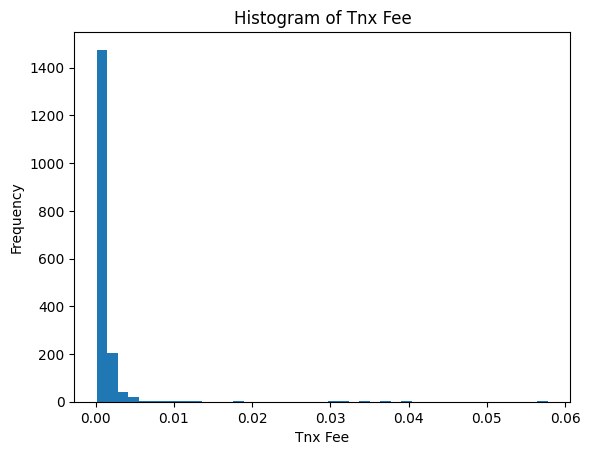

In [13]:
tnx_fee = df['tnx_fee'].loc[df['tnx_fee'] != 0]
sq_root_of_pop = int(np.ceil(np.sqrt(len(df))))
plt.hist(df['tnx_fee'], bins= sq_root_of_pop)
plt.xlabel('Tnx Fee')
plt.ylabel('Frequency')
plt.title('Histogram of Tnx Fee')
plt.show()

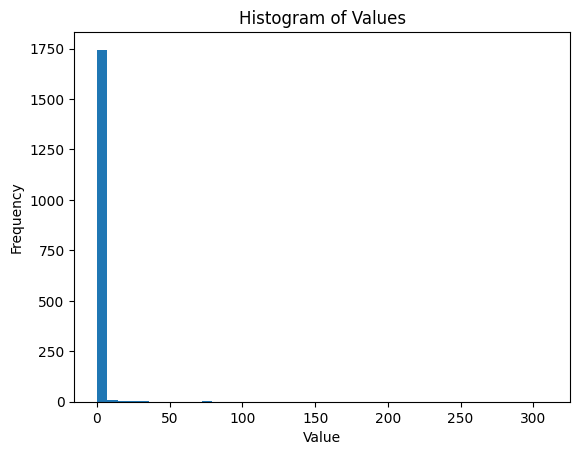

In [14]:
value = df['value'].loc[df['value'] != 0]
plt.hist(df['value'], bins= sq_root_of_pop)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()


#### Normal Distribution

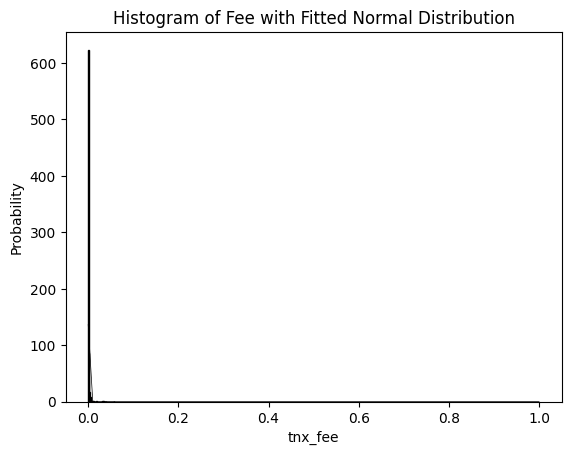

In [17]:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
calculated_fee_pdf = 1 / (df['tnx_fee'].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - df['tnx_fee'].mean()) / df['tnx_fee'].std()) ** 2)

plt.hist(df["tnx_fee"], bins=sq_root_of_pop, density=True, color='red', edgecolor='black')
plt.plot(x, calculated_fee_pdf, 'k', linewidth=0.5)
plt.title("Histogram of Fee with Fitted Normal Distribution")
plt.xlabel("tnx_fee")
plt.ylabel("Probability")
plt.show()

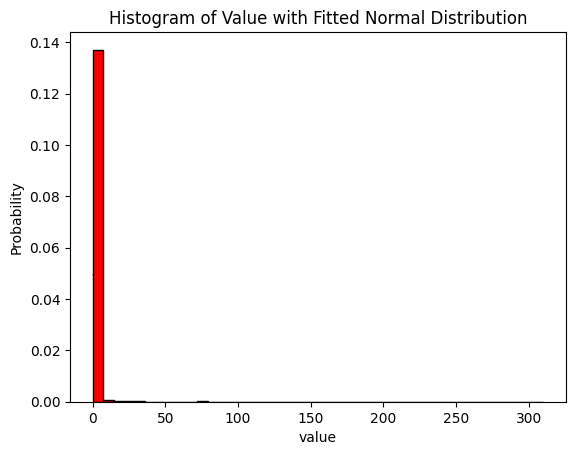

In [19]:
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
calculated_value_pdf = 1 / (df['value'].std() * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - df['value'].mean()) / df['value'].std()) ** 2)

plt.hist(df["value"], bins=sq_root_of_pop, density=True, color='red', edgecolor='black')
plt.plot(x, calculated_value_pdf, 'k', linewidth=0.5)
plt.title("Histogram of Value with Fitted Normal Distribution")
plt.xlabel("value")
plt.ylabel("Probability")
plt.show()

#### Boxplot & Violinplot

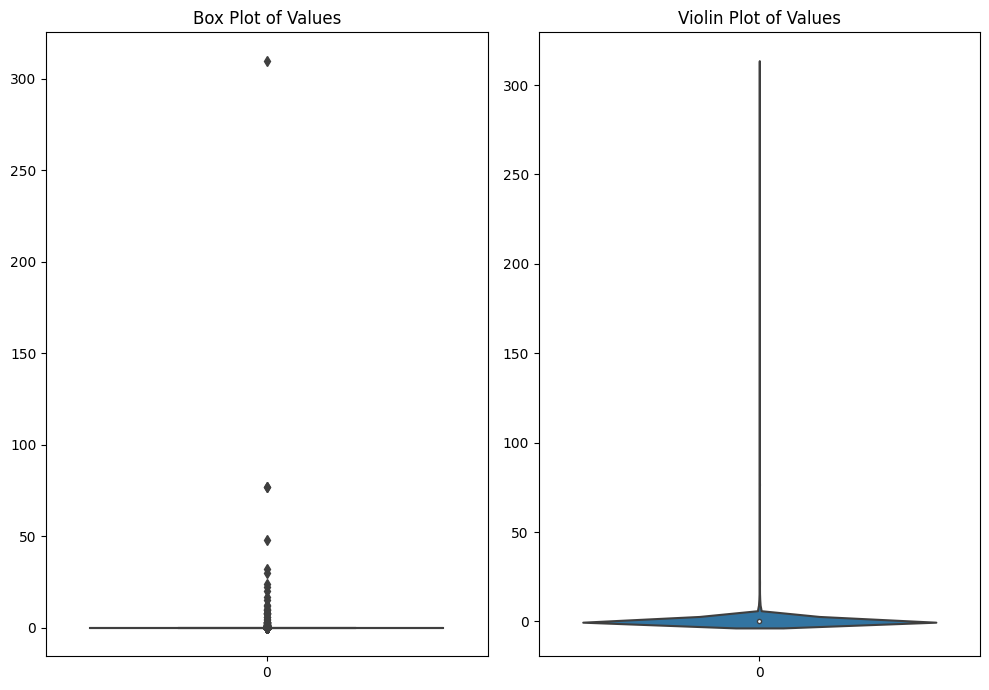

In [20]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["value"])
plt.title("Box Plot of Values")
plt.subplot(1, 2, 2)
sns.violinplot(df["value"])
plt.title("Violin Plot of Values")
plt.tight_layout()
plt.show()

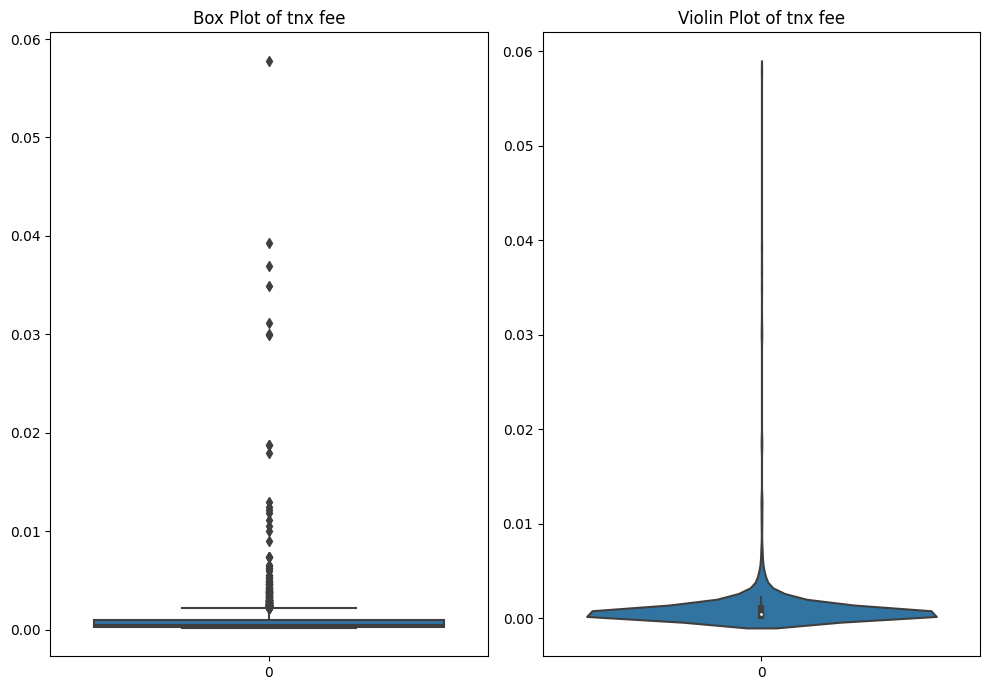

In [21]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
sns.boxplot(df["tnx_fee"])
plt.title("Box Plot of tnx fee")
plt.subplot(1, 2, 2)
sns.violinplot(df["tnx_fee"])
plt.title("Violin Plot of tnx fee")
plt.tight_layout()
plt.show()

# Data Sampling and Analysis

### Simple Random Sampling

In [23]:
df_random_sample = pd.DataFrame()

shape of sample dataframe:  (88, 1)
Mean of sample:  0.0012936496590909093
Standard Deviation of sample:  0.003764953995899567


C:\Users\Ahmadreza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


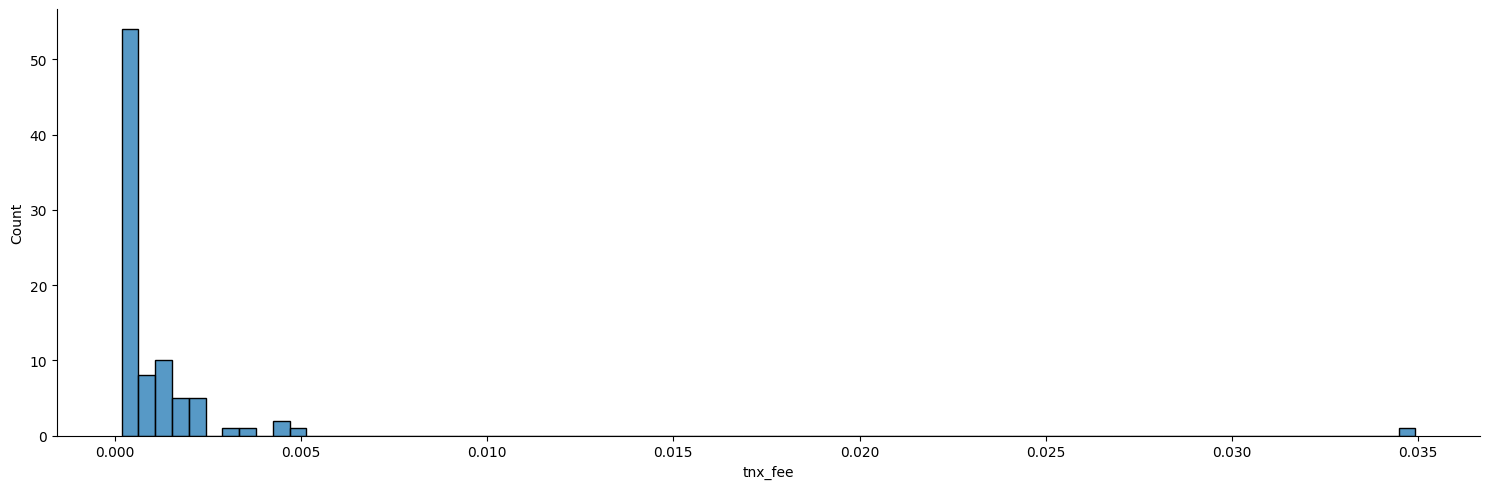

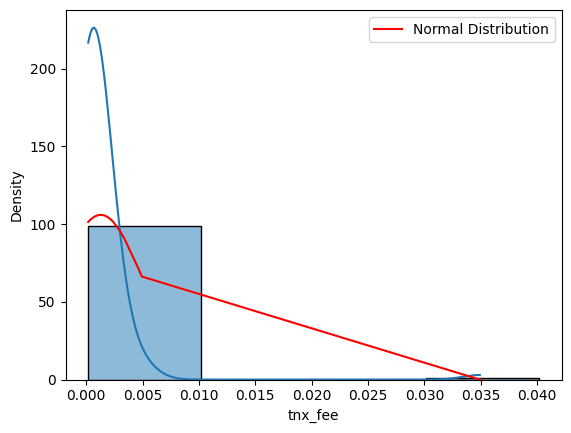

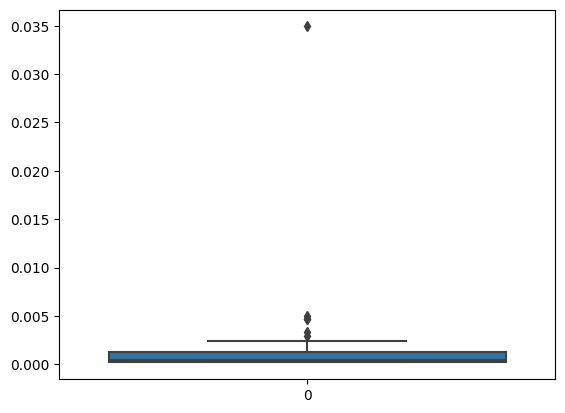

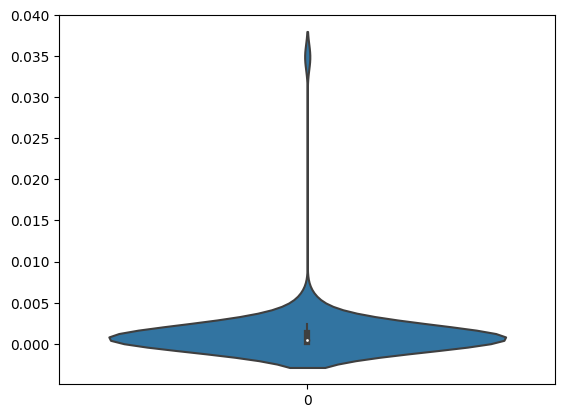

In [24]:
df_random_sample['tnx_fee'] = df['tnx_fee'].sample(frac = 0.05, random_state= 42, ignore_index= True)
print('shape of sample dataframe: ', df_random_sample.shape)
print("Mean of sample: ", df_random_sample['tnx_fee'] .mean())
print("Standard Deviation of sample: ", df_random_sample['tnx_fee'] .std())


sns.displot(df_random_sample['tnx_fee'], kde= False, aspect= 3, height= 5)
plt.show()

sns.histplot(df_random_sample['tnx_fee'], kde= True, stat= "density", binwidth=0.01)
x = sorted(df_random_sample['tnx_fee'])
y = norm.pdf(x, loc=df_random_sample['tnx_fee'].mean(), scale=df_random_sample['tnx_fee'].std())
plt.plot(x, y, color='r', label='Normal Distribution')
plt.legend()
plt.show()

sns.boxplot(df_random_sample['tnx_fee'])
plt.show()

sns.violinplot(df_random_sample['tnx_fee'] )
plt.show()

Mean of sample:  0.932335148076923
Standard Deviation of sample:  4.776155189901197


C:\Users\Ahmadreza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


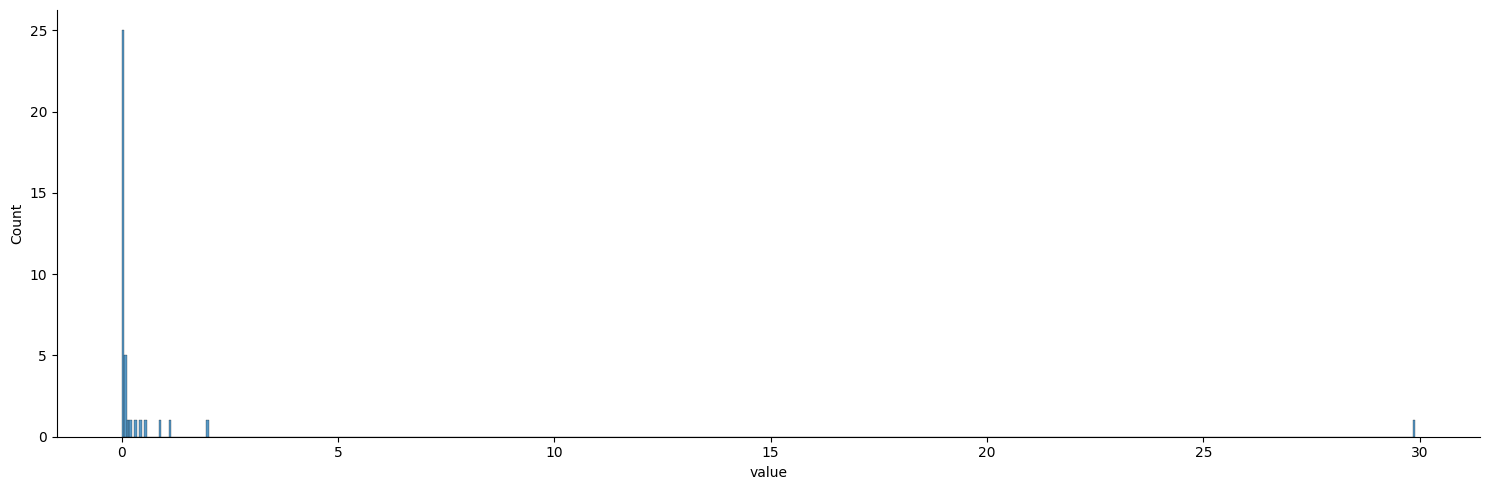

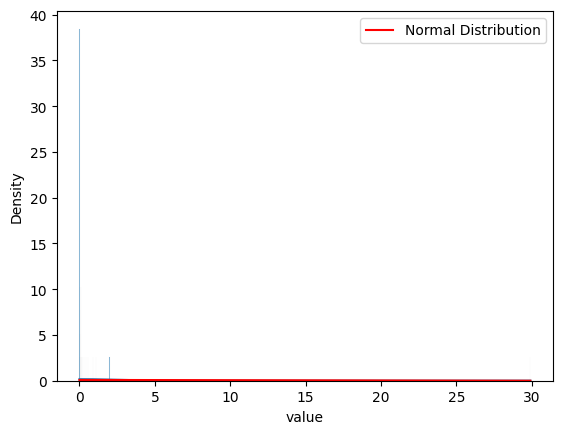

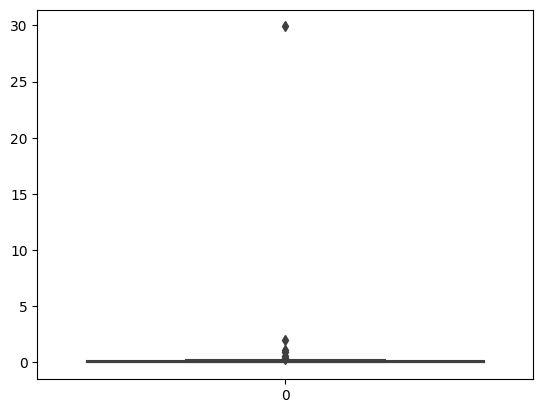

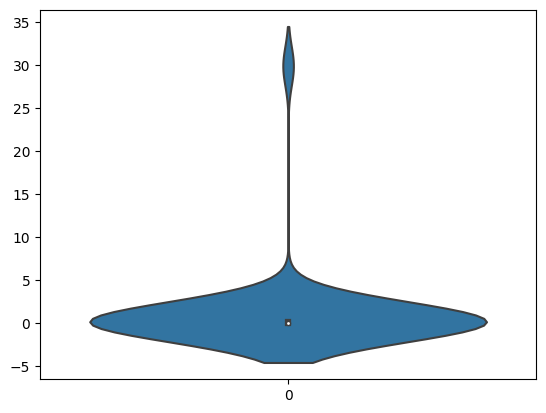

In [25]:
df_random_sample['value'] = value.sample(frac = 0.05, random_state= 42, ignore_index= True)
print("Mean of sample: ", df_random_sample['value'] .mean())
print("Standard Deviation of sample: ", df_random_sample['value'] .std())


sns.displot(df_random_sample['value'], kde= False, aspect= 3, height= 5)
plt.show()

sns.histplot(df_random_sample['value'], kde= True, stat= "density", binwidth=0.01)
x = sorted(df_random_sample['value'])
y = norm.pdf(x, loc=df_random_sample['value'].mean(), scale=df_random_sample['value'].std())
plt.plot(x, y, color='r', label='Normal Distribution')
plt.legend()
plt.show()

sns.boxplot(df_random_sample['value'])
plt.show()

sns.violinplot(df_random_sample['value'] )
plt.show()


In [29]:
df_random_sample.describe()

,tnx_fee,value
count,88.000000,3.900000e+01
mean,0.001294,9.323351e-01
std,0.003765,4.776155e+00
min,0.000182,4.000000e-09
25%,0.000237,3.103138e-03
50%,0.000483,2.092276e-02
75%,0.001246,1.007950e-01
max,0.034924,2.990000e+01


### Stratified Sampling

In [28]:
from sklearn.utils import resample

#stratified sampling 
stratified_sample_method = df.groupby(['method'], as_index=False).apply(lambda x: resample(x, n_samples=3))

# stratified_sample_value = df.groupby(['method'], agroup_keys=False).apply(lambda x: x.sample(frac=0.05, random_state=42))


stratified_sample_method

tnx_hash  \
0   1153  0x4d8fcd2f2cf2d9eed9d1536337980b98e2c5b41ff4ee...   
    2696  0xc718f5c2eff18ecfb55ec2ba8fa7f95e126953c32b07...   
    2696  0xc718f5c2eff18ecfb55ec2ba8fa7f95e126953c32b07...   
1   2150  0xf76ad486c6a3cde5838ae86bc343bf76088d0a76ebf0...   
    2007  0x1d1cab59ab176e8b8d1d0c2df1081ad6ada7cbe6b39c...   
...                                                     ...   
211 1526  0x1bd8e5f0e0c75bac95d2aa4e82e53c2eb0e2521f24f1...   
    2067  0xa7e19c3e817e984f7fadacd544c613dd08eac5ce2b1e...   
212 141   0xfe00ef41ed107b1041adc06a35f3bdb89f5288fae3eb...   
    141   0xfe00ef41ed107b1041adc06a35f3bdb89f5288fae3eb...   
    141   0xfe00ef41ed107b1041adc06a35f3bdb89f5288fae3eb...   

                       method     block                 date  \
0   1153           0x00000000  19667707  2024-04-16 11:20:47   
    2696           0x00000000  19667700  2024-04-16 11:19:23   
    2696           0x00000000  19667700  2024-04-16 11:19:23   
1   2150           0x00000195  19667702  2024-04-16 11:19:47   
    2007           0x00000195  19667703  2024-04-16 11:19:59   
...                       ...       ...                  ...   
211 1526  Withdraw Multipl...  19667705  2024-04-16 11:20:23   
    2067  Withdraw Multipl...  19667703  2024-04-16 11:19:59   
212 141   Withdraw Self Ap...  19667710  2024-04-16 11:21:23   
    141   Withdraw Self Ap...  19667710  2024-04-16 11:21:23   
    141   Withdraw Self Ap...  19667710  2024-04-16 11:21:23   

                                                from  \
0   1153  0x8236c0cc4736da88f1814a3632dc860af0bac733   
    2696  0x0cf4010a5a28b4eed8ebf329828ca9807d7c0d41   
    2696  0x0cf4010a5a28b4eed8ebf329828ca9807d7c0d41   
1   2150  0x961e1a2f0df7fb9441a519871c8121a7ac427100   
    2007  0x853a8793c0b4d8a1199ae935fc8498c5f8372f7e   
...                                              ...   
211 1526  0x9aeb4ad9e4ce1d5ce16b72141705553915440007   
    2067  0x9aeb4ad9e4ce1d5ce16b72141705553915440007   
212 141   0x3036532f9d2f57ff778f1e60a8bdf7e8ff2fd81b   
    141   0x3036532f9d2f57ff778f1e60a8bdf7e8ff2fd81b   
    141   0x3036532f9d2f57ff778f1e60a8bdf7e8ff2fd81b   

                                                  to     value   tnx_fee  
0   1153  0x0000000000000068f116a894984e2db1123eb395  0.012500  0.001572  
    2696  0x0000000000000068f116a894984e2db1123eb395  0.089999  0.001303  
    2696  0x0000000000000068f116a894984e2db1123eb395  0.089999  0.001303  
1   2150  0x3a23f943181408eac424116af7b7790c94cb97a5  0.000981  0.000665  
    2007  0x3a23f943181408eac424116af7b7790c94cb97a5  0.163440  0.000670  
...                                              ...       ...       ...  
211 1526  0x418749e294cabce5a714efccc22a8aade6f9db57  0.000000  0.001712  
    2067  0xd09a57127bc40d680be7cb061c2a6629fe71abef  0.000000  0.002021  
212 141   0x5954ab967bc958940b7eb73ee84797dc8a2afbb9  0.000000  0.000618  
    141   0x5954ab967bc958940b7eb73ee84797dc8a2afbb9  0.000000  0.000618  
    141   0x5954ab967bc958940b7eb73ee84797dc8a2afbb9  0.000000  0.000618  

[639 rows x 8 columns]

In [30]:
stratified_sample_method.describe()

,value,tnx_fee
count,6.390000e+02,639.000000
mean,8.653538e-01,0.002943
std,7.543044e+00,0.006200
min,0.000000e+00,0.000214
25%,0.000000e+00,0.000973
50%,0.000000e+00,0.001512
75%,4.000000e-09,0.002410
max,7.700000e+01,0.057800


# Questions

**1. What are some potential limitations when using web scraping for data collection? Speciﬁcally, what problems did you face while fetching data from Etherscan? What problems can these limitations cause in your analysis?**




Web scraping for data collection has several limitations to consider. These include changes in website structure, IP blocking or rate limiting, captchas and anti-scraping measures, and potential data inconsistencies or errors. When fetching data from Etherscan or similar blockchain explorers, additional challenges may arise, such as dealing with dynamic content and being mindful of rate limits. These limitations can result in incomplete or interrupted data collection, inaccuracies in the scraped data, and potential biases in the analysis, ultimately impacting the validity and reliability of the findings.

To mitigate these limitations, it is important to stay updated with website changes, implement strategies to handle IP blocking or rate limiting, and address captchas or anti-scraping mechanisms as necessary. Additionally, validating the scraped data, cross-referencing with other reliable sources, and conducting thorough data quality checks can help detect and correct inconsistencies or errors. Understanding these limitations and their potential impact on the analysis is crucial for making informed decisions and ensuring the trustworthiness of the collected data and subsequent analysis.

**2. What can make your analysis untrustworthy? What are your solutions?**

Factors that can make an analysis untrustworthy include biased or incomplete data, inaccurate or unreliable data sources,and inappropriate statistical methods or assumptions. Biased or incomplete data can lead to inaccurate conclusions, while unreliable data sources and incorrect assumptions can introduce errors. Inappropriate statistical methods can lead to flawed analysis.

To ensure the trustworthiness of an analysis, it is crucial to implement appropriate solutions. This includes ensuring data collection methods are unbiased and representative, validating data through cross-referencing and quality checks,and using appropriate statistical methods and considering model assumptions. By addressing these factors and implementing the solutions, the analysis can be made more reliable, robust, and trustworthy, enhancing the validity and credibility of the findings.

**3. How did the visualization help you in understanding the data? What could you interpret from the plots?**

The visualization helped with understanding the distrubation of the data. It also helped with finding the outliers in our data. Another useful insight given by the visualization is a simpler and better understanding of how the data is distributed.

**4. How do the two sampling methods differ in their output? Compare these and explain which one is a better ﬁt to the population**  

In simple random sampling, each element in the population has an equal chance of being selected independently. Random samples are selected without any consideration for the population's characteristics or attributes. The resulting sample is representative of the overall population, but it may not necessarily reflect the distribution or characteristics of specific subgroups within the population.

Stratified sampling involves dividing the population into distinct subgroups or strata based on some shared characteristic or attribute. Random samples are then drawn from each stratum in proportion to its representation in the overall population. This method ensures that each subgroup is adequately represented in the sample, allowing for more precise estimates and analysis within each subgroup. The resulting sample reflects the distribution and characteristics of each stratum, providing more accurate insights into specific subgroups.

Simple random sampling is useful when you want a general representation of the entire population and don't require specific information about subgroups. Stratified sampling is useful when you want to ensure representation from different subgroups or when you want to compare and analyze specific subgroups separately.